#***Consideraciones:***
# **ICA**

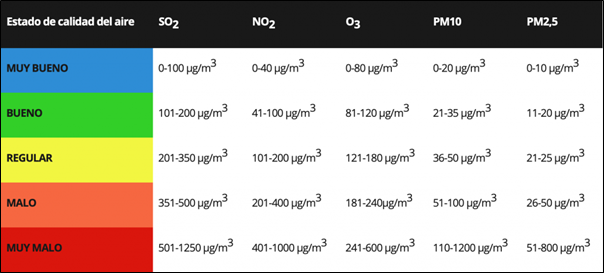

#***Protocolos para altas contaminación en Madrid:***

#**- NO2 (10-12-2018)**
Protocolo con medidas de actuación.

Normal: <= 180 ug/m3
Preaviso: > 180 y <= 200 ug/m3
Aviso: > 200 y <= 400 ug/m3
Alerta: > 400 ug/m3

-> Valores de NO2 en el rango normal en este rango de tiempo y estaciones.

In [1]:
# General
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import warnings
warnings.filterwarnings('ignore')

# Preprocessing

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler

# Modeling

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier

# Evaluation

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, recall_score, confusion_matrix, precision_recall_fscore_support
from sklearn.metrics import roc_auc_score,auc,f1_score
from sklearn.metrics import precision_recall_curve,roc_curve


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#**DataSet**

In [3]:
data = pd.read_csv('/content/drive/MyDrive/data_CA/master_v_mplus_short.csv')

In [4]:
data.head()

,estacion,fecha,año,dia_año,mes,dia_mes,dia_tipo,prec,tmed,hrmed,...,presmed,dioxido_nitrogeno,monoxido_nitrogeno,oxido_nitrogeno,ozono,pm25,pm10,intensidad,ocupacion,carga
0,BARAJAS,2017-01-01,2017,1,1,1,No_LAB,0.0,0.2,84.0,...,957.80,45.0,27.0,86.0,11.0,NoInfo,NoInfo,156.769704,4.503079,15.968596
1,BARAJAS,2017-01-02,2017,2,1,2,LAB,0.0,2.8,86.0,...,954.30,52.0,37.0,109.0,13.0,NoInfo,NoInfo,226.734193,6.647023,23.390424
2,BARAJAS,2017-01-03,2017,3,1,3,LAB,0.0,5.5,79.0,...,956.65,64.0,81.0,189.0,6.0,NoInfo,NoInfo,238.387793,7.379162,24.723798
3,BARAJAS,2017-01-04,2017,4,1,4,LAB,0.0,5.2,86.0,...,958.20,67.0,87.0,200.0,4.0,NoInfo,NoInfo,238.496010,8.069368,25.219767
4,BARAJAS,2017-01-05,2017,5,1,5,LAB,0.0,5.3,92.0,...,956.95,63.0,59.0,153.0,6.0,NoInfo,NoInfo,234.923786,7.814997,24.885065


In [5]:
max(data.dioxido_nitrogeno)

147.0

In [6]:
data['NO2_nivelesICA'] = pd.cut(data.dioxido_nitrogeno, [0, 40, 100, 200, 400, 1000], labels=['MUY BUENO', 'BUENO', 'REGULAR', 'MALO', 'MUY MALO'])

In [7]:
data.NO2_nivelesICA.value_counts() # data desbalanceada -> MUY BUENO / NO MUY BUENO

MUY BUENO    6844
BUENO        3314
REGULAR        64
MALO            0
MUY MALO        0
Name: NO2_nivelesICA, dtype: int64

In [8]:
data['NO2_niveles'] = pd.cut(data.dioxido_nitrogeno, [0, 40, 1000], labels=['MUY BUENO', 'NO MUY BUENO'])
data.NO2_niveles.value_counts()

MUY BUENO       6844
NO MUY BUENO    3378
Name: NO2_niveles, dtype: int64

In [9]:
y = data['NO2_niveles']

In [10]:
data.columns

Index(['estacion', 'fecha', 'año', 'dia_año', 'mes', 'dia_mes', 'dia_tipo',
       'prec', 'tmed', 'hrmed', 'velmed', 'dir', 'presmed',
       'dioxido_nitrogeno', 'monoxido_nitrogeno', 'oxido_nitrogeno', 'ozono',
       'pm25', 'pm10', 'intensidad', 'ocupacion', 'carga', 'NO2_nivelesICA',
       'NO2_niveles'],
      dtype='object')

In [11]:
data.drop(columns=['estacion', 'fecha', 'año', 'dia_año', 'mes', 'dia_mes', 'dioxido_nitrogeno',
                   'pm25', 'pm10', 'ozono', 'intensidad', 'ocupacion', 'NO2_nivelesICA', 'NO2_niveles'], inplace=True)
X = data

In [12]:
X.head()

,dia_tipo,prec,tmed,hrmed,velmed,dir,presmed,monoxido_nitrogeno,oxido_nitrogeno,carga
0,No_LAB,0.0,0.2,84.0,1.7,99.0,957.80,27.0,86.0,15.968596
1,LAB,0.0,2.8,86.0,1.7,99.0,954.30,37.0,109.0,23.390424
2,LAB,0.0,5.5,79.0,0.8,20.0,956.65,81.0,189.0,24.723798
3,LAB,0.0,5.2,86.0,1.9,22.0,958.20,87.0,200.0,25.219767
4,LAB,0.0,5.3,92.0,1.7,26.0,956.95,59.0,153.0,24.885065


In [13]:
y.head()

0    NO MUY BUENO
1    NO MUY BUENO
2    NO MUY BUENO
3    NO MUY BUENO
4    NO MUY BUENO
Name: NO2_niveles, dtype: category
Categories (2, object): ['MUY BUENO' < 'NO MUY BUENO']

#**EDA and Preprocessing**

In [14]:
print(y.value_counts(), '%', y.value_counts()*100/y.size)  # Target

MUY BUENO       6844
NO MUY BUENO    3378
Name: NO2_niveles, dtype: int64 % MUY BUENO       66.940532
NO MUY BUENO    33.039906
Name: NO2_niveles, dtype: float64


There is some disproportion between groups; however, since the minority class (NMB - 33%) not constitutes less than 20% of the total data, the data will be considered not imbalanced. So, under or oversampling techniques are not addressed.

In [15]:
X.describe(include='all').T # Features

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
dia_tipo,10224,2,LAB,6948,NaN,NaN,NaN,NaN,NaN,NaN,NaN
prec,10224.0,NaN,NaN,NaN,1.138487,4.182197,0.0,0.0,0.0,0.0,91.2
tmed,10224.0,NaN,NaN,NaN,16.024554,7.825588,-6.2,9.5,15.1,22.4,34.4
hrmed,10224.0,NaN,NaN,NaN,54.274045,19.188356,15.0,38.0,52.0,68.05,100.0
velmed,10224.0,NaN,NaN,NaN,2.475141,1.493608,0.0,1.4,2.2,3.1,12.2
dir,10224.0,NaN,NaN,NaN,27.620755,26.840118,1.0,12.0,22.0,27.0,99.0
presmed,10224.0,NaN,NaN,NaN,942.723289,7.17015,912.1,938.0,941.75,947.7,967.65
monoxido_nitrogeno,10224.0,NaN,NaN,NaN,17.046808,24.875396,0.0,3.0,8.0,20.0,254.0
oxido_nitrogeno,10224.0,NaN,NaN,NaN,60.927321,55.647935,0.0,25.0,43.0,77.0,519.0
carga,10224.0,NaN,NaN,NaN,18.833822,5.412244,1.437926,15.178395,18.657494,22.902749,37.41723


In [16]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10224 entries, 0 to 10223
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   dia_tipo            10224 non-null  object 
 1   prec                10224 non-null  float64
 2   tmed                10224 non-null  float64
 3   hrmed               10224 non-null  float64
 4   velmed              10224 non-null  float64
 5   dir                 10224 non-null  float64
 6   presmed             10224 non-null  float64
 7   monoxido_nitrogeno  10224 non-null  float64
 8   oxido_nitrogeno     10224 non-null  float64
 9   carga               10224 non-null  float64
dtypes: float64(9), object(1)
memory usage: 798.9+ KB


In [17]:
X.isnull().sum().sum()

0

Variales sin valores nulos (nulls).

In [18]:
X.columns

Index(['dia_tipo', 'prec', 'tmed', 'hrmed', 'velmed', 'dir', 'presmed',
       'monoxido_nitrogeno', 'oxido_nitrogeno', 'carga'],
      dtype='object')

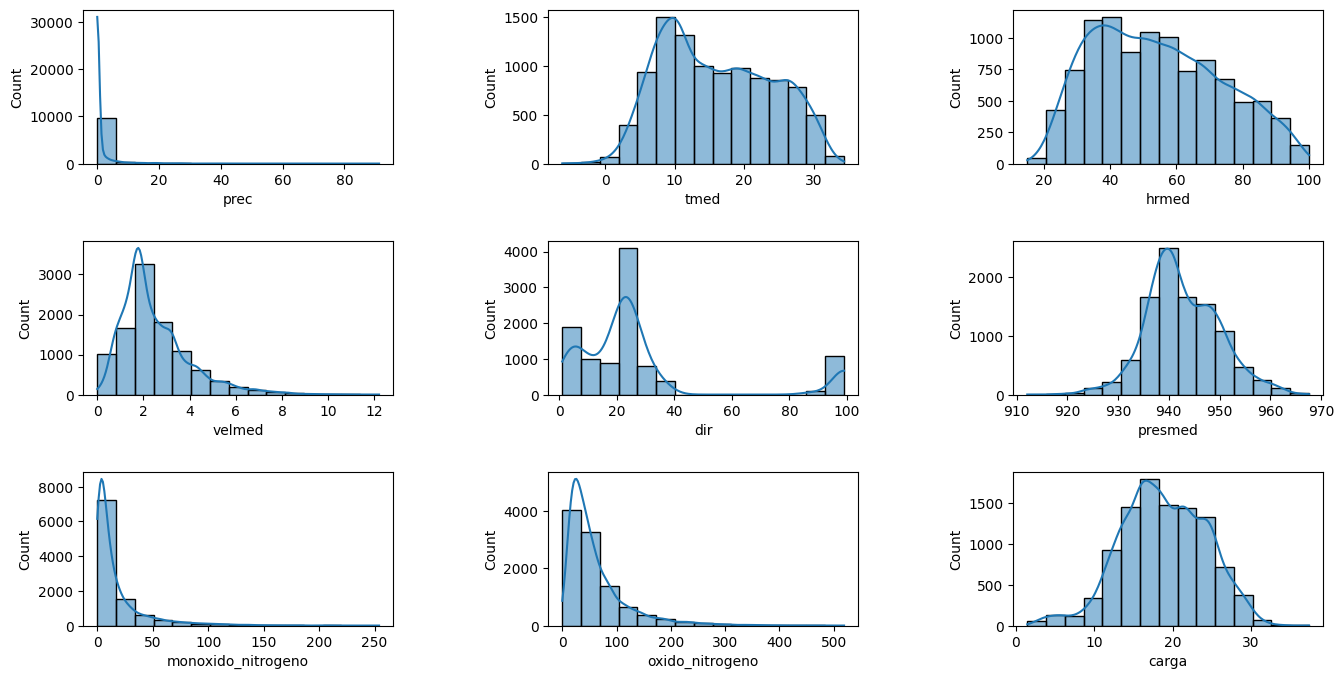

In [19]:
continuous_v = ['prec', 'tmed', 'hrmed', 'velmed', 'dir', 'presmed',
                'monoxido_nitrogeno', 'oxido_nitrogeno', 'carga']

plt.figure(1 , figsize = (16 , 8))
n = 0
for v in continuous_v:
    n += 1
    plt.subplot(3, 3, n)
    plt.subplots_adjust(hspace = 0.5 , wspace = 0.5)
    sns.histplot(X, x=X[v], bins = 15, kde=True)
plt.show()

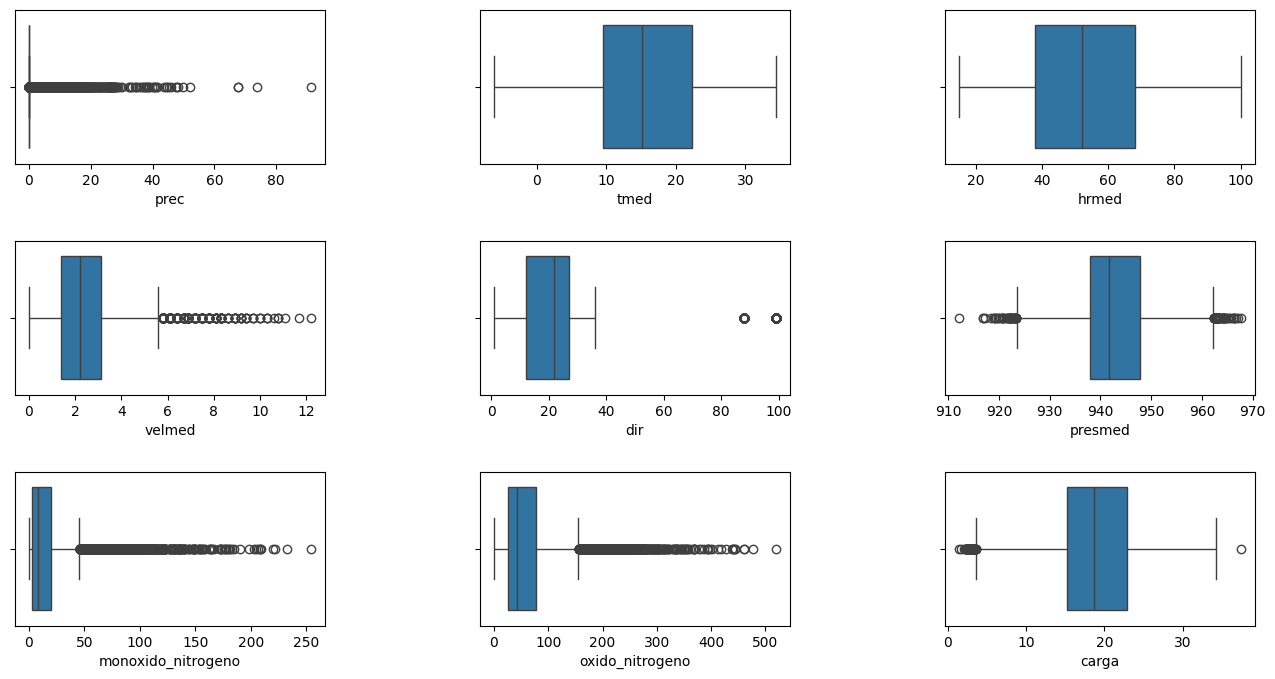

In [20]:
plt.figure(1 , figsize = (16 , 8))
n = 0
for v in continuous_v:
    n += 1
    plt.subplot(3, 3, n)
    plt.subplots_adjust(hspace = 0.5 , wspace = 0.5)
    sns.boxplot(X, x=X[v])
plt.show()

Variables no normales con outliers y diferencias en las escalas -> RobustScaler (robust to outliers) paara transformar features.

In [21]:
# Scaling dia_tipo
X.dia_tipo = pd.DataFrame(LabelEncoder().fit_transform(X.dia_tipo), columns=['dia_tipo'])
X.head()

,dia_tipo,prec,tmed,hrmed,velmed,dir,presmed,monoxido_nitrogeno,oxido_nitrogeno,carga
0,1,0.0,0.2,84.0,1.7,99.0,957.80,27.0,86.0,15.968596
1,0,0.0,2.8,86.0,1.7,99.0,954.30,37.0,109.0,23.390424
2,0,0.0,5.5,79.0,0.8,20.0,956.65,81.0,189.0,24.723798
3,0,0.0,5.2,86.0,1.9,22.0,958.20,87.0,200.0,25.219767
4,0,0.0,5.3,92.0,1.7,26.0,956.95,59.0,153.0,24.885065


In [22]:
# Split

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=8)

In [23]:
# Scaling

num_pipeline = Pipeline(steps=[('rs', RobustScaler())])

pre = ColumnTransformer(
    transformers=[
        ('num', num_pipeline, continuous_v)
    ]
    , remainder='passthrough'
    , sparse_threshold=0
    , verbose_feature_names_out=False
)

x_train_p = pd.DataFrame(data=pre.fit_transform(x_train),
                         columns=pre.get_feature_names_out())


x_test_p = pd.DataFrame(data=pre.transform(x_test)
    , columns=pre.get_feature_names_out())


y_train_p = pd.DataFrame(LabelEncoder().fit_transform(y_train), columns=['NO2_niveles'])

y_test_p = pd.DataFrame(LabelEncoder().fit_transform(y_test), columns=['NO2_niveles'])

In [24]:
x_train_p.head()

,prec,tmed,hrmed,velmed,dir,presmed,monoxido_nitrogeno,oxido_nitrogeno,carga,dia_tipo
0,0.0,0.515385,-0.741935,1.000000,0.133333,1.000000,0.0625,-0.019608,0.307412,0.0
1,0.0,0.776923,-0.548387,-0.176471,5.133333,1.112821,-0.3125,-0.176471,0.522224,0.0
2,0.0,-0.430769,0.967742,0.529412,0.200000,0.210256,0.4375,0.392157,0.593967,0.0
3,0.0,0.615385,-0.741935,-0.294118,0.066667,-0.317949,0.5000,0.509804,0.358883,0.0
4,0.0,-0.307692,0.483871,0.000000,-0.066667,0.358974,2.1250,1.470588,-0.474648,0.0


In [25]:
x_test_p.head()

,prec,tmed,hrmed,velmed,dir,presmed,monoxido_nitrogeno,oxido_nitrogeno,carga,dia_tipo
0,0.0,1.169231,-0.677419,-0.294118,0.133333,-0.143590,0.0000,0.156863,-0.166154,0.0
1,0.0,-0.123077,0.129032,-0.176471,-0.133333,1.446154,0.2500,0.470588,0.938906,0.0
2,0.0,0.584615,0.000000,1.000000,5.133333,-0.830769,-0.1875,-0.215686,-0.410102,0.0
3,0.0,1.153846,-0.645161,-0.176471,-1.133333,-0.400000,-0.0625,-0.019608,0.361215,0.0
4,0.0,-0.646154,0.451613,-1.117647,-1.000000,1.153846,4.5000,2.627451,-0.003684,0.0


In [26]:
y_train_p.head()

,NO2_niveles
0,0
1,0
2,1
3,1
4,1


In [27]:
y_test_p.head()

,NO2_niveles
0,0
1,1
2,0
3,0
4,1


#**Models Training**

#***Logistic Regression***

In [28]:
lg = LogisticRegression(random_state=8, max_iter=1000)
param_lg = [{
    'solver':['lbfgs', 'newton-cg', 'newton-cholesky', 'sag']
    , 'C': [1, 10, 100]
    , 'penalty':['l2']
},{
    'solver':['liblinear']
    , 'C': [1, 10, 100]
    , 'penalty': ['l1', 'l2']
},{
    'solver':['saga']
    , 'C': [1, 10, 100]
    , 'penalty': ['l1', 'l2', 'elasticnet']
}]

gs_lg = GridSearchCV(
    estimator=lg
    , param_grid=param_lg
    , cv=5
    , verbose=2
    , scoring='roc_auc'
)

gs_lg.fit(x_train_p, y_train_p)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV] END ......................C=1, penalty=l2, solver=lbfgs; total time=   0.4s
[CV] END ......................C=1, penalty=l2, solver=lbfgs; total time=   0.5s
[CV] END ......................C=1, penalty=l2, solver=lbfgs; total time=   0.3s
[CV] END ......................C=1, penalty=l2, solver=lbfgs; total time=   0.6s
[CV] END ......................C=1, penalty=l2, solver=lbfgs; total time=   0.6s
[CV] END ..................C=1, penalty=l2, solver=newton-cg; total time=   0.2s
[CV] END ..................C=1, penalty=l2, solver=newton-cg; total time=   0.2s
[CV] END ..................C=1, penalty=l2, solver=newton-cg; total time=   0.2s
[CV] END ..................C=1, penalty=l2, solver=newton-cg; total time=   0.2s
[CV] END ..................C=1, penalty=l2, solver=newton-cg; total time=   0.2s
[CV] END ............C=1, penalty=l2, solver=newton-cholesky; total time=   0.1s
[CV] END ............C=1, penalty=l2, solver=ne

GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=1000, random_state=8),
             param_grid=[{'C': [1, 10, 100], 'penalty': ['l2'],
                          'solver': ['lbfgs', 'newton-cg', 'newton-cholesky',
                                     'sag']},
                         {'C': [1, 10, 100], 'penalty': ['l1', 'l2'],
                          'solver': ['liblinear']},
                         {'C': [1, 10, 100],
                          'penalty': ['l1', 'l2', 'elasticnet'],
                          'solver': ['saga']}],
             scoring='roc_auc', verbose=2)

In [29]:
gs_lg.best_estimator_.get_params() # Best parameters (tested) for this model.

{'C': 1,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 1000,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 8,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [30]:
# For evaluation
metrics = pd.DataFrame(columns=['Algorithm', 'Accuracy_train', 'Precision_train',
                                'Recall_train', 'f1-score_train', 'Accuracy_test',
                                'Precision_test', 'Recall_test', 'f1-score_test'])
metrics['Algorithm'] = ['Logistic Regression', 'Decision Trees', 'SVMs', 'Random Forest', 'ADABoost', 'XGBoost' ]

In [31]:
# For evaluation

cr_lg_train = classification_report(y_train_p, gs_lg.predict(x_train_p), output_dict=True)
metrics.loc[0,'Accuracy_train']=cr_lg_train['accuracy']
metrics.loc[0,'Precision_train']=cr_lg_train['1']['precision']
metrics.loc[0,'Recall_train']=cr_lg_train['1']['recall']
metrics.loc[0, 'f1-score_train']=cr_lg_train['1']['f1-score']

cr_lg_test = classification_report(y_test_p, gs_lg.predict(x_test_p), output_dict=True)
metrics.loc[0,'Accuracy_test']=cr_lg_test['accuracy']
metrics.loc[0,'Precision_test']=cr_lg_test['1']['precision']
metrics.loc[0,'Recall_test']=cr_lg_test['1']['recall']
metrics.loc[0, 'f1-score_test']=cr_lg_test['1']['f1-score']


In [32]:
# For visualization

lg_imp = pd.DataFrame(gs_lg.best_estimator_.feature_names_in_, columns=['Variables'])
lg_imp['Coefficients'] = pd.DataFrame(gs_lg.best_estimator_.coef_).T.iloc[:,0]

#sns.barplot(lg_imp.sort_values('Coefficients', ascending=0), x='Coefficients', y='Variables', color='darkblue')

#***Decision Trees***

In [33]:
dt = DecisionTreeClassifier(random_state=8)
param_dt = {
    'criterion':['gini', 'log_loss', 'entropy'],
    'max_features':['sqrt', 'log2', None],
    'max_depth':[None, 10, 25, 50]
}

gs_dt = GridSearchCV(
    estimator=dt
    , param_grid=param_dt
    , cv=5
    , scoring='roc_auc'
)

gs_dt.fit(x_train_p, y_train_p)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=8),
             param_grid={'criterion': ['gini', 'log_loss', 'entropy'],
                         'max_depth': [None, 10, 25, 50],
                         'max_features': ['sqrt', 'log2', None]},
             scoring='roc_auc')

In [34]:
gs_dt.best_estimator_.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 8,
 'splitter': 'best'}

In [35]:
# For evaluation

cr_dt_train = classification_report(y_train_p, gs_dt.predict(x_train_p), output_dict=True)
metrics.loc[1,'Accuracy_train']=cr_dt_train['accuracy']
metrics.loc[1,'Precision_train']=cr_dt_train['1']['precision']
metrics.loc[1,'Recall_train']=cr_dt_train['1']['recall']
metrics.loc[1, 'f1-score_train']=cr_dt_train['1']['f1-score']

cr_dt_test = classification_report(y_test_p, gs_dt.predict(x_test_p), output_dict=True)
metrics.loc[1,'Accuracy_test']=cr_dt_test['accuracy']
metrics.loc[1,'Precision_test']=cr_dt_test['1']['precision']
metrics.loc[1,'Recall_test']=cr_dt_test['1']['recall']
metrics.loc[1, 'f1-score_test']=cr_dt_test['1']['f1-score']

In [36]:
# For visualization

dt_imp =[(feat, imp) for feat, imp in zip(gs_dt.best_estimator_.feature_names_in_, gs_dt.best_estimator_.feature_importances_)]
dt_imp = pd.DataFrame(dt_imp, columns=['col', 'f score'])

#sns.barplot(dt_imp.sort_values('f score', ascending=0), x='f score', y='col', color='darkblue')

#***SVMs***

In [37]:
svc = SVC(random_state=8)  # testing just linear kernel since the one that allows extract coefficients for features importance
param_svc = [
    {'kernel':['linear'], 'C': [1, 10, 100]}
    , {'kernel':['linear'], 'C':[1, 10, 100], 'gamma':[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]}
    , {'kernel':['linear'], 'C': [1, 10, 100], 'gamma':[0.1, 0.2, 0.3, 0.4, 0.5]
       , 'degree':[2, 3, 4, 5]}
]

gs_svc = GridSearchCV(
    estimator=svc
    , param_grid=param_svc
    , cv=5
    , verbose=2
    , scoring='roc_auc'
)

gs_svc.fit(x_train_p, y_train_p)

Fitting 5 folds for each of 87 candidates, totalling 435 fits
[CV] END .................................C=1, kernel=linear; total time=   0.3s
[CV] END .................................C=1, kernel=linear; total time=   0.3s
[CV] END .................................C=1, kernel=linear; total time=   0.3s
[CV] END .................................C=1, kernel=linear; total time=   0.3s
[CV] END .................................C=1, kernel=linear; total time=   0.4s
[CV] END ................................C=10, kernel=linear; total time=   0.3s
[CV] END ................................C=10, kernel=linear; total time=   0.4s
[CV] END ................................C=10, kernel=linear; total time=   0.3s
[CV] END ................................C=10, kernel=linear; total time=   1.0s
[CV] END ................................C=10, kernel=linear; total time=   0.4s
[CV] END ...............................C=100, kernel=linear; total time=   1.0s
[CV] END ...............................C=100, 

GridSearchCV(cv=5, estimator=SVC(random_state=8),
             param_grid=[{'C': [1, 10, 100], 'kernel': ['linear']},
                         {'C': [1, 10, 100],
                          'gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8],
                          'kernel': ['linear']},
                         {'C': [1, 10, 100], 'degree': [2, 3, 4, 5],
                          'gamma': [0.1, 0.2, 0.3, 0.4, 0.5],
                          'kernel': ['linear']}],
             scoring='roc_auc', verbose=2)

In [38]:
gs_svc.best_estimator_.get_params()

{'C': 1,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'linear',
 'max_iter': -1,
 'probability': False,
 'random_state': 8,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [39]:
# For evaluation

cr_svc_train = classification_report(y_train_p, gs_svc.predict(x_train_p), output_dict=True)
metrics.loc[2,'Accuracy_train']=cr_svc_train['accuracy']
metrics.loc[2,'Precision_train']=cr_svc_train['1']['precision']
metrics.loc[2,'Recall_train']=cr_svc_train['1']['recall']
metrics.loc[2, 'f1-score_train']=cr_svc_train['1']['f1-score']

cr_svc_test = classification_report(y_test_p, gs_svc.predict(x_test_p), output_dict=True)
metrics.loc[2,'Accuracy_test']=cr_svc_test['accuracy']
metrics.loc[2,'Precision_test']=cr_svc_test['1']['precision']
metrics.loc[2,'Recall_test']=cr_svc_test['1']['recall']
metrics.loc[2, 'f1-score_test']=cr_svc_test['1']['f1-score']


In [40]:
# For visualization

svm_imp = pd.DataFrame(gs_svc.best_estimator_.feature_names_in_, columns=['Variables']) # only linear kernerl
svm_imp['Coefficients'] = pd.DataFrame(gs_svc.best_estimator_.coef_).T.iloc[:,0]

#sns.barplot(svm_imp.sort_values('Coefficients', ascending=0), y='Variables', x='Coefficients', color='darkblue')

#***Random Forest***

In [41]:
rf = RandomForestClassifier(random_state=8)
param_rf = {
    'criterion':['gini', 'log_loss', 'entropy'],
    'max_features':['sqrt', 'log2', None],
    'max_depth':[None, 10, 25],
    'n_estimators':[10, 25, 50]
}

gs_rf = GridSearchCV(
    estimator=rf
    , param_grid = param_rf
    , cv=5
    , scoring='roc_auc'
)

gs_rf.fit(x_train_p, y_train_p)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=8),
             param_grid={'criterion': ['gini', 'log_loss', 'entropy'],
                         'max_depth': [None, 10, 25],
                         'max_features': ['sqrt', 'log2', None],
                         'n_estimators': [10, 25, 50]},
             scoring='roc_auc')

In [42]:
gs_rf.best_estimator_.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 10,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 8,
 'verbose': 0,
 'warm_start': False}

In [43]:
# For evaluation

cr_rf_train = classification_report(y_train_p, gs_rf.predict(x_train_p), output_dict=True)
metrics.loc[3,'Accuracy_train']=cr_rf_train['accuracy']
metrics.loc[3,'Precision_train']=cr_rf_train['1']['precision']
metrics.loc[3,'Recall_train']=cr_rf_train['1']['recall']
metrics.loc[3, 'f1-score_train']=cr_rf_train['1']['f1-score']

cr_rf_test = classification_report(y_test_p, gs_rf.predict(x_test_p), output_dict=True)
metrics.loc[3,'Accuracy_test']=cr_rf_test['accuracy']
metrics.loc[3,'Precision_test']=cr_rf_test['1']['precision']
metrics.loc[3,'Recall_test']=cr_rf_test['1']['recall']
metrics.loc[3, 'f1-score_test']=cr_rf_test['1']['f1-score']

In [44]:
# For visualization

rf_imp =[(feat, imp) for feat, imp in zip(gs_rf.best_estimator_.feature_names_in_, gs_rf.best_estimator_.feature_importances_)]
rf_imp = pd.DataFrame(rf_imp, columns=['col', 'f score'])

#sns.barplot(rf_imp.sort_values('f score', ascending=0), y='col', x='f score', color='darkblue')

#***ADABoost***

In [45]:
ada = AdaBoostClassifier(random_state=0)
param_ada = {
    'n_estimators':[10, 25, 50, 100]
    , 'learning_rate':[0.3, 0.5, 1.0]
}

gs_ada = GridSearchCV(
    estimator=ada
    , cv = 5
    , verbose=2
    , param_grid=param_ada
    , scoring='roc_auc'
)

gs_ada.fit(x_train_p, y_train_p)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END .................learning_rate=0.3, n_estimators=10; total time=   0.1s
[CV] END .................learning_rate=0.3, n_estimators=10; total time=   0.1s
[CV] END .................learning_rate=0.3, n_estimators=10; total time=   0.1s
[CV] END .................learning_rate=0.3, n_estimators=10; total time=   0.1s
[CV] END .................learning_rate=0.3, n_estimators=10; total time=   0.1s
[CV] END .................learning_rate=0.3, n_estimators=25; total time=   0.2s
[CV] END .................learning_rate=0.3, n_estimators=25; total time=   0.2s
[CV] END .................learning_rate=0.3, n_estimators=25; total time=   0.2s
[CV] END .................learning_rate=0.3, n_estimators=25; total time=   0.2s
[CV] END .................learning_rate=0.3, n_estimators=25; total time=   0.2s
[CV] END .................learning_rate=0.3, n_estimators=50; total time=   0.4s
[CV] END .................learning_rate=0.3, n_e

GridSearchCV(cv=5, estimator=AdaBoostClassifier(random_state=0),
             param_grid={'learning_rate': [0.3, 0.5, 1.0],
                         'n_estimators': [10, 25, 50, 100]},
             scoring='roc_auc', verbose=2)

In [46]:
gs_ada.best_estimator_.get_params()

{'algorithm': 'SAMME.R',
 'base_estimator': 'deprecated',
 'estimator': None,
 'learning_rate': 0.3,
 'n_estimators': 10,
 'random_state': 0}

In [47]:
# For evaluation

cr_ada_train = classification_report(y_train_p, gs_ada.predict(x_train_p), output_dict=True)
metrics.loc[4,'Accuracy_train']=cr_ada_train['accuracy']
metrics.loc[4,'Precision_train']=cr_ada_train['1']['precision']
metrics.loc[4,'Recall_train']=cr_ada_train['1']['recall']
metrics.loc[4, 'f1-score_train']=cr_ada_train['1']['f1-score']

cr_ada_test = classification_report(y_test_p, gs_ada.predict(x_test_p), output_dict=True)
metrics.loc[4,'Accuracy_test']=cr_ada_test['accuracy']
metrics.loc[4,'Precision_test']=cr_ada_test['1']['precision']
metrics.loc[4,'Recall_test']=cr_ada_test['1']['recall']
metrics.loc[4, 'f1-score_test']=cr_ada_test['1']['f1-score']

In [48]:
# For visualization

ada_imp =[(feat, imp) for feat, imp in zip(gs_ada.best_estimator_.feature_names_in_, gs_ada.best_estimator_.feature_importances_)]
ada_imp = pd.DataFrame(ada_imp, columns=['col', 'f score'])

#sns.barplot(ada_imp.sort_values('f score', ascending=0), y='col', x='f score', color='darkblue')

#***XGBoost***

In [49]:
param_xgb = {"objective":["binary:logistic"]
          ,'colsample_bytree': [0.3],
          'learning_rate': [0.1],
          'max_depth': [5, 10, 15]
          ,'alpha': [10]}

gs_xgb = GridSearchCV(
    estimator=XGBClassifier(random_state=0)
    , cv=5
    , scoring='roc_auc'
    , verbose=2
    , param_grid=param_xgb
)

gs_xgb.fit(x_train_p, y_train_p)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] END alpha=10, colsample_bytree=0.3, learning_rate=0.1, max_depth=5, objective=binary:logistic; total time=   0.3s
[CV] END alpha=10, colsample_bytree=0.3, learning_rate=0.1, max_depth=5, objective=binary:logistic; total time=   0.3s
[CV] END alpha=10, colsample_bytree=0.3, learning_rate=0.1, max_depth=5, objective=binary:logistic; total time=   0.2s
[CV] END alpha=10, colsample_bytree=0.3, learning_rate=0.1, max_depth=5, objective=binary:logistic; total time=   0.3s
[CV] END alpha=10, colsample_bytree=0.3, learning_rate=0.1, max_depth=5, objective=binary:logistic; total time=   0.2s
[CV] END alpha=10, colsample_bytree=0.3, learning_rate=0.1, max_depth=10, objective=binary:logistic; total time=   0.3s
[CV] END alpha=10, colsample_bytree=0.3, learning_rate=0.1, max_depth=10, objective=binary:logistic; total time=   0.3s
[CV] END alpha=10, colsample_bytree=0.3, learning_rate=0.1, max_depth=10, objective=binary:logistic; tota

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=0, ...),
             param_grid={'alpha': [10], 'colsample_bytree': [0.3],
                         'learning_rate': [0.1], 'max_depth': [5, 10, 15],
                         'objective': ['binary:logistic']},
             scoring='roc_auc', verbose=2)

In [50]:
gs_xgb.best_estimator_.get_params()

{'objective': 'multi:softprob',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': 0.3,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': 0.1,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': 5,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': None,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': 0,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None,
 'alpha': 10}

In [51]:
# For evaluation

cr_xgb_train = classification_report(y_train_p, gs_xgb.predict(x_train_p), output_dict=True)
metrics.loc[5,'Accuracy_train']=cr_xgb_train['accuracy']
metrics.loc[5,'Precision_train']=cr_xgb_train['1']['precision']
metrics.loc[5,'Recall_train']=cr_xgb_train['1']['recall']
metrics.loc[5, 'f1-score_train']=cr_xgb_train['1']['f1-score']

cr_xgb_test = classification_report(y_test_p, gs_xgb.predict(x_test_p), output_dict=True)
metrics.loc[5,'Accuracy_test']=cr_xgb_test['accuracy']
metrics.loc[5,'Precision_test']=cr_xgb_test['1']['precision']
metrics.loc[5,'Recall_test']=cr_xgb_test['1']['recall']
metrics.loc[5, 'f1-score_test']=cr_xgb_test['1']['f1-score']

In [52]:
# For visualization

xgb_imp =[(feat, imp) for feat, imp in zip(gs_xgb.best_estimator_.feature_names_in_, gs_xgb.best_estimator_.feature_importances_)]
xgb_imp = pd.DataFrame(xgb_imp, columns=['col', 'f score'])

#sns.barplot(xgb_imp.sort_values('f score', ascending=0), y='col', x='f score', color='darkblue')

#**Models Evaluation**

***Features importance for each model tested***

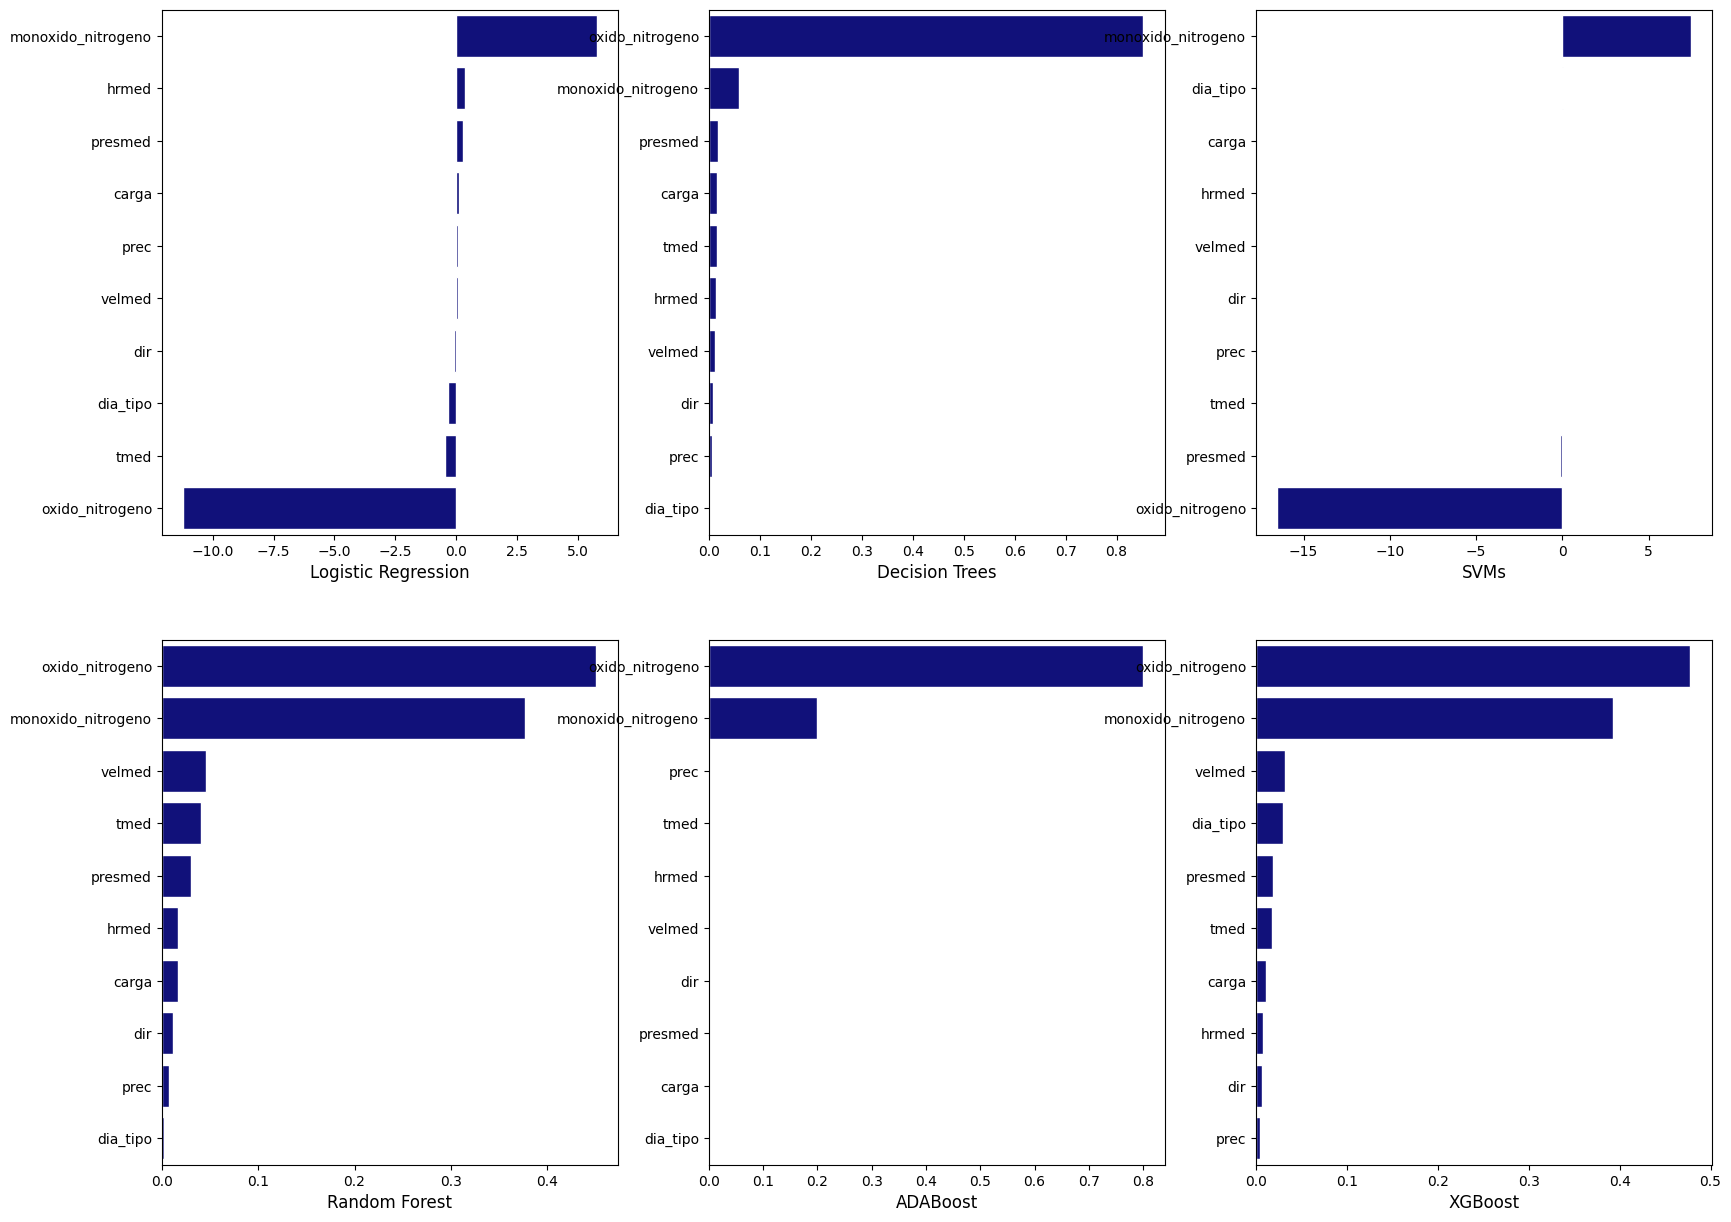

In [53]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20,15))
sns.set_style('whitegrid')

sns.barplot(lg_imp.sort_values('Coefficients', ascending=0), x='Coefficients', y='Variables', ax=axes[0,0], color='darkblue')
sns.barplot(dt_imp.sort_values('f score', ascending=0), x='f score', y='col', ax=axes[0,1], color='darkblue')
sns.barplot(svm_imp.sort_values('Coefficients', ascending=0), x='Coefficients', y='Variables', ax=axes[0,2], color='darkblue')
sns.barplot(rf_imp.sort_values('f score', ascending=0), x='f score', y='col', ax=axes[1,0], color='darkblue')
sns.barplot(ada_imp.sort_values('f score', ascending=0), x='f score', y='col', ax=axes[1,1], color='darkblue')
sns.barplot(xgb_imp.sort_values('f score', ascending=0), x='f score', y='col', ax=axes[1,2], color='darkblue')

axes[0,0].set_xlabel('Logistic Regression', fontsize='large')
axes[0,1].set_xlabel('Decision Trees', fontsize='large')
axes[0,2].set_xlabel('SVMs', fontsize='large')
axes[1,0].set_xlabel('Random Forest', fontsize='large')
axes[1,1].set_xlabel('ADABoost', fontsize='large')
axes[1,2].set_xlabel('XGBoost', fontsize='large')

axes[0,0].set_ylabel('')
axes[0,1].set_ylabel('')
axes[0,2].set_ylabel('')
axes[1,0].set_ylabel('')
axes[1,1].set_ylabel('')
axes[1,2].set_ylabel('')

plt.show()

***Metrics by Model***

In [54]:
metrics

,Algorithm,Accuracy_train,Precision_train,Recall_train,f1-score_train,Accuracy_test,Precision_test,Recall_test,f1-score_test
0,Logistic Regression,0.98814,0.987566,0.976892,0.9822,0.992176,0.989899,0.98705,0.988473
1,Decision Trees,1.0,1.0,1.0,1.0,0.963814,0.936709,0.958273,0.947368
2,SVMs,0.989974,0.986542,0.9836,0.985069,0.992665,0.988506,0.989928,0.989216
3,Random Forest,0.998655,0.998507,0.997391,0.997949,0.974572,0.966618,0.958273,0.962428
4,ADABoost,0.945103,0.922147,0.90943,0.915744,0.948166,0.927431,0.919424,0.92341
5,XGBoost,0.970779,0.951292,0.960865,0.956054,0.965281,0.940678,0.958273,0.949394


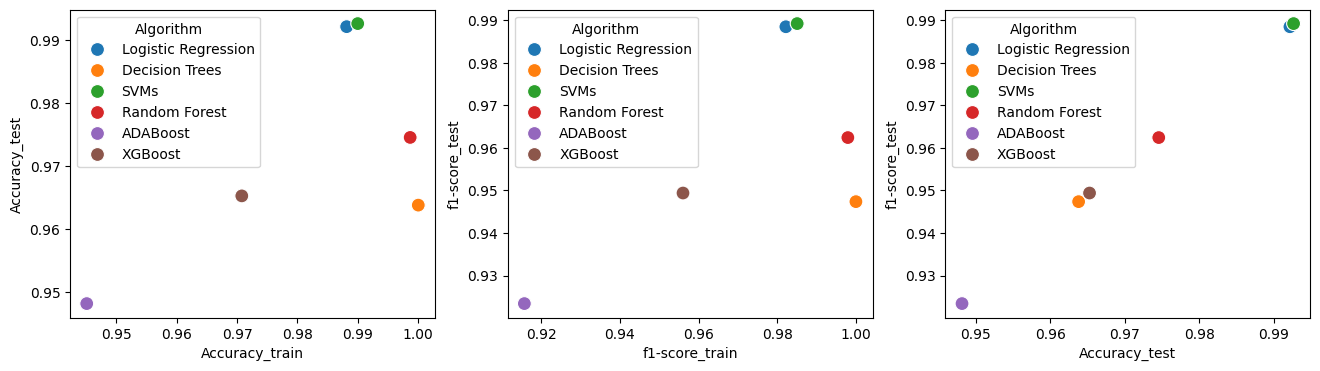

In [57]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 4))

plt.style.use('default')
plt.rcParams['lines.markersize'] = 10
sns.scatterplot(metrics, x='Accuracy_train', y='Accuracy_test', hue='Algorithm', ax=axes[0] )
sns.scatterplot(metrics, x='f1-score_train', y='f1-score_test', hue='Algorithm', ax=axes[1])
sns.scatterplot(metrics, x='Accuracy_test', y='f1-score_test', hue='Algorithm', ax=axes[2])

plt.show()

In [58]:
gs_svc.best_estimator_.get_params()

{'C': 1,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'linear',
 'max_iter': -1,
 'probability': False,
 'random_state': 8,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [59]:
from sklearn.inspection import permutation_importance

model = SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
            decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
            max_iter=-1, probability=False, random_state=8, shrinking=True, tol=0.001, verbose=False).fit(x_train_p, y_train_p)

imps = permutation_importance(model, x_test_p, y_test_p,
                              n_repeats = 50,
                              random_state=8)

Text(0.5, 1.01, 'Permutation Importances Test SVC')

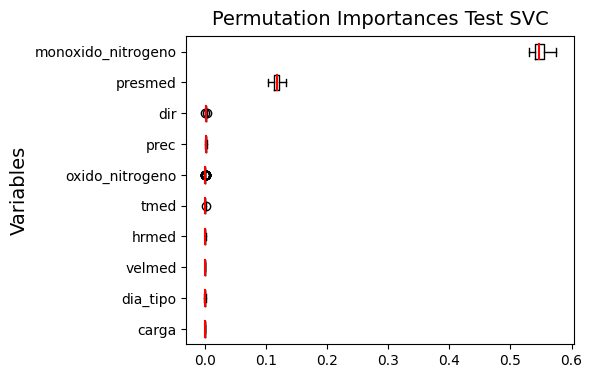

In [61]:
fig = plt.figure(1 , figsize = (5 , 4))
perm_sorted_idx = imps.importances_mean.argsort()
plt.boxplot(imps.importances[perm_sorted_idx].T, vert=False,
            labels=x_test.columns[perm_sorted_idx], medianprops = dict(color ='red', linewidth = 1.5))

plt.style.use('default')
plt.ylabel('Variables', fontsize=14)
plt.title('Permutation Importances Test SVC', fontsize=14, y=1.01)